# Byesian model reduction for neural networks

Here we will utilise a shallow neural network, to test how Bayesian priors over weights influence the classification performance. A shellow neural network cosnist of a single hidden layer and an output mapped to image labels via a categorical likelihood. We can write the generative model as 
\begin{equation}
    \prod_{n=1}^N p\left(l_n| \pmb{X}_n, \pmb{\Theta}\right) = \prod_{n=1}^N \prod_{k=1}^K \rho_{n,k}^{\delta_{k,l_n}}
\end{equation}
where $\pmb{\Theta} = \left(\pmb{W_1}, \ldots, \pmb{W}_L \right)$, and
$$ \rho_{n,k} = s_{\max}\left(\pmb{W}_L \cdot [\pmb{f}(\pmb{W}, \pmb{X}_n); 1] \right)$$

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import jax.numpy as jnp
from jax import random, vmap, nn, lax, devices, device_put
from jax.nn import one_hot
import matplotlib.pyplot as plt
import seaborn as sns

print(devices('gpu'))
rng_key = random.PRNGKey(0)

[StreamExecutorGpuDevice(id=0, process_index=0), StreamExecutorGpuDevice(id=1, process_index=0)]


In [3]:
from numpyro import sample, param, handlers, prng_key
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal, AutoDelta
from numpyro.optim import optax_to_numpyro
import optax

import equinox as eqx
from numpyro import module, param, handlers, plate, subsample, sample, deterministic
import numpyro.distributions as dist

from functools import partial

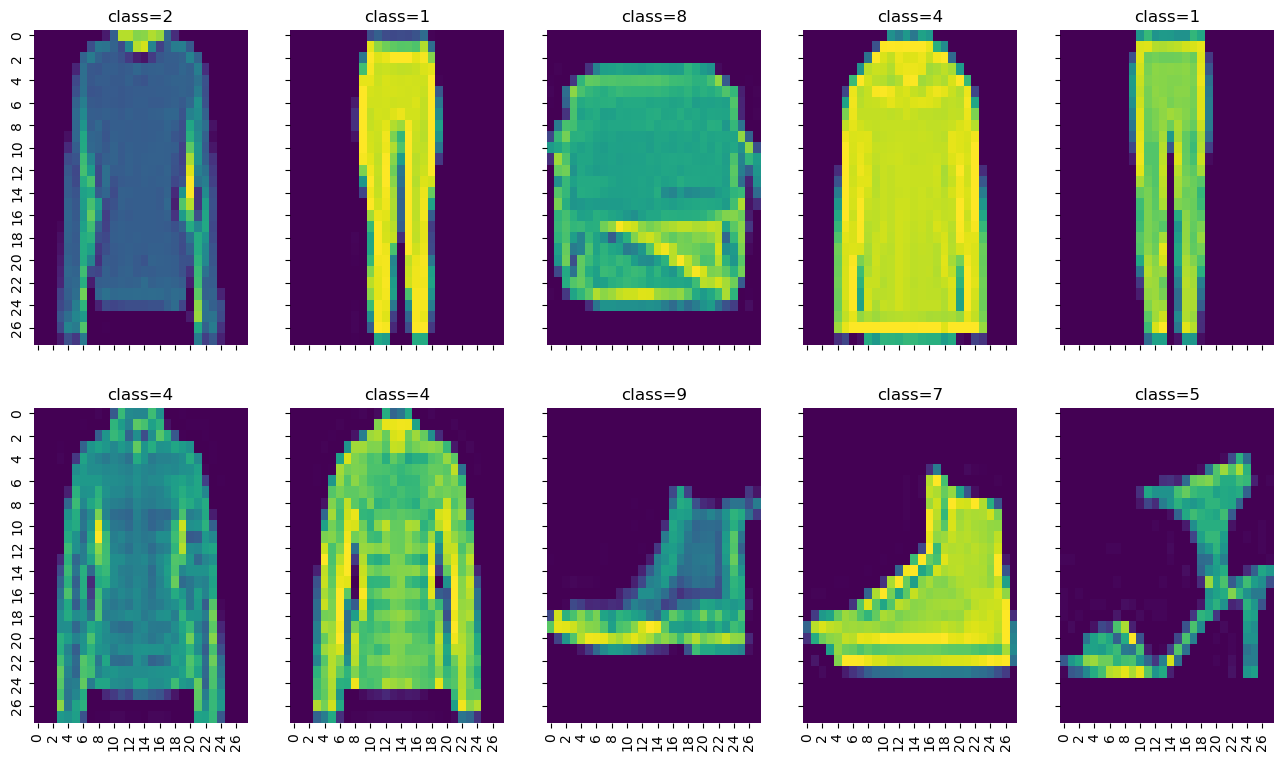

In [4]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')
fig, axes = plt.subplots(2, 5, figsize=(16, 9), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].squeeze(), cmap='viridis', ax = axes[0, n], cbar=False, vmax=1., vmin=0.)
    axes[0, n].set_title('class={}'.format(train_ds['label'][n]))
    sns.heatmap(test_ds['image'][n].squeeze(), cmap='viridis', ax = axes[1, n], cbar=False, vmax=1., vmin=0.)
    axes[1, n].set_title('class={}'.format(test_ds['label'][n]))


train_ds['image'] = train_ds['image'].squeeze().reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].squeeze().reshape(test_ds['image'].shape[0], -1)

_, in_size = train_ds['image'].shape
out_size = len(jnp.unique(train_ds['label']))

# number of neurons in hidden layer
num_hn = [10, 20, 40, 60, 80, 100, 200]

In [5]:
def register_network_parameters(nnet):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                new_lv += (param(f'loc.layer{l}.{name}', value),)
            else:
                new_lv += (value,)

        new_vals.append( layer.tree_unflatten(l_aux, new_lv) )

    vals = (new_vals,) + vals[1:]
    params = params.tree_unflatten(aux, vals)

    return eqx.combine(params, static)


def likelihood(nnet, images, labels, subsample_size, sigma):
    n, _ = images.shape

    with plate("n", n, subsample_size=subsample_size):
        batch_x = subsample(images, event_dim=1)
        pred = nnet(batch_x)
        
        if labels is not None:
            batch_y = nn.one_hot(subsample(labels, event_dim=0), out_size)
        else:
            batch_y = None
        
        sample(
            "obs", dist.Normal(pred, sigma).to_event(1), obs=batch_y
        )


def model(nnet, images, sigma=1, labels=None, subsample_size=None):
    nnet = vmap(register_network_parameters(nnet))
    likelihood(nnet, images, labels, subsample_size, sigma)


def test_model(rng_key, model, params, nnet, images, labels, guide=None, num_samples=1):
    pred = Predictive(model, guide=guide, params=params, num_samples=num_samples)

    n, _ = images.shape
    sample = pred(rng_key, nnet, images, sigma=1e-6)

    _labels = sample['obs'].argmax(-1)
    if num_samples > 1:
        acc = jnp.mean(_labels == labels, -1)
        print(acc.mean(), acc.std())
    else:
        print( jnp.mean(_labels == labels) )


with handlers.seed(rng_seed=0):
    for nh in num_hn:
        dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=1, activation=nn.swish, key=random.PRNGKey(0))
        model(dense_net, train_ds['image'], labels=train_ds['label'])


1 200


100%|██████████| 200000/200000 [04:27<00:00, 746.41it/s, init loss: 583726.7500, avg. loss [190001-200000]: 553645.0625]


0.8953
3 200


100%|██████████| 200000/200000 [06:34<00:00, 506.76it/s, init loss: 581579.1250, avg. loss [190001-200000]: 551546.6250]


0.8915


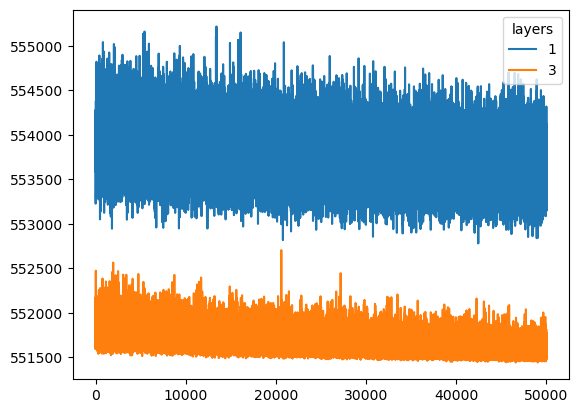

In [21]:
def guide(*args, **kwargs):
        pass

rng_key = random.PRNGKey(0)

for nh in num_hn[-1:]:
        for depth in range(1, 4, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-4))
                svi = SVI(model, guide, optimizer, Trace_ELBO())

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 200000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=256);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, model, results.params, dense_net, test_ds['image'], test_ds['label'])

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

In [6]:
from jax import linearize

def linearize_nnet(nnet, Ws, x):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    def f(p):
        nn = eqx.combine(p, static)
        return vmap(nn)(x)

    out, f_jvp = linearize(f, params)

    return out + f_jvp(Ws)

def register_random_network_parameters(nnet, sigma_0=1.):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    new_lv += (sample(f'layer{l}.{name}', dist.Normal(0., sigma_0).expand(list(value.shape)).to_event(1)),)
                else:
                    new_lv += (sample(f'layer{l}.{name}', dist.Normal(0., sigma_0).expand(list(value.shape)).to_event(1)),)
            else:
                new_lv += (value,)

        new_vals.append( layer.tree_unflatten(l_aux, new_lv) )

    vals = (new_vals,) + vals[1:]
    params = params.tree_unflatten(aux, vals)

    return eqx.combine(params, static)

def rrnp(nnet, sigma_0=1.):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    new_lv += (sample(f'layer{l}.{name}', dist.Normal(value, sigma_0).to_event(1)),)
                else:
                    new_lv += (sample(f'layer{l}.{name}', dist.Normal(value, sigma_0).to_event(1)),)
            else:
                new_lv += (value,)

        new_vals.append( layer.tree_unflatten(l_aux, new_lv) )

    vals = (new_vals,) + vals[1:]
    params = params.tree_unflatten(aux, vals)

    return eqx.combine(params, static)

def model_test(nnet, images, sigma=1, labels=None, subsample_size=None):
    d_nnet = register_network_parameters(nnet)
    r_nnet = rrnp(d_nnet)
    Ws, _ = eqx.partition(r_nnet, eqx.is_inexact_array)
    lin_nnet = partial(linearize_nnet, d_nnet, Ws)
    likelihood(lin_nnet, images, labels, subsample_size, sigma)

def guide_test(nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(0., scale).to_event(1))
                else:
                    name = f'layer{l}.{name}'
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(0., scale).to_event(1))

def bayes_model(nnet, images, sigma=1, labels=None, subsample_size=None):
    nnet = vmap(register_random_network_parameters(nnet))
    likelihood(nnet, images, labels, subsample_size, sigma)

def delta_guide(nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                name = f'layer{l}.{name}'
                loc = param('loc_' + name, value)
                sample(name, dist.Delta(loc).to_event(1))

def normal_guide(nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value.copy())
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(loc, scale).to_event(1))
                else:
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value.copy())
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(loc, scale).to_event(1))

def ktied_guide(rank, nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(0., scale).to_event(1))
                else:
                    name = f'layer{l}.{name}'
                    i, j = value.shape
                    scale_u = param('scale_u.' + name, jnp.ones((i, rank))/jnp.sqrt(10 * rank))
                    scale_v = param('scale_v.' + name, jnp.ones((rank, j))/jnp.sqrt(10 * rank))
                    scale = deterministic('scale.' + name, jnp.abs(scale_u @ scale_v))
                    sample(name, dist.Normal(0., scale).to_event(1))


def lowrank_guide(rank, nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(0., scale).to_event(1))
                else:
                    name = f'layer{l}.{name}'
                    i, j = value.shape
                    cov_diag = param('cov_diag.' + name, jnp.ones((i, j)), constraint=dist.constraints.softplus_positive)
                    cov_factor = param('cov_factor.' + name, jnp.zeros((i, j, rank)))
                    sample(name, dist.LowRankMultivariateNormal(jnp.zeros((i, j)), cov_factor, cov_diag))

1 80


100%|██████████| 100000/100000 [02:32<00:00, 654.11it/s, init loss: 641103.1250, avg. loss [95001-100000]: 613337.6250]


0.88159996
3 80


100%|██████████| 100000/100000 [03:22<00:00, 494.55it/s, init loss: 655910.7500, avg. loss [95001-100000]: 622867.5625]


0.8872
5 80


100%|██████████| 100000/100000 [04:01<00:00, 414.77it/s, init loss: 665950.6250, avg. loss [95001-100000]: 634554.0000]


0.88909996


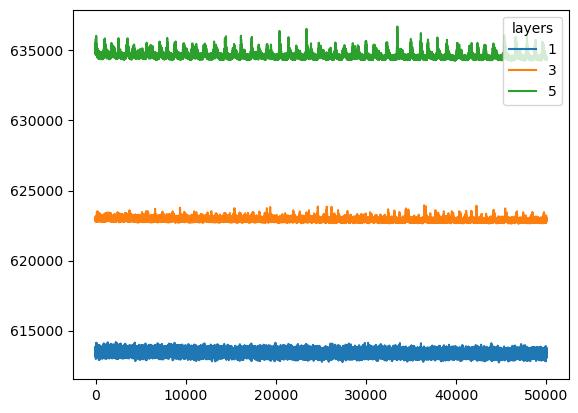

In [27]:
guide = delta_guide

for nh in num_hn[-3:-2]:
        for depth in range(1, 6, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-3))
                svi = SVI(bayes_model, guide, optimizer, Trace_ELBO())

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 100000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=1024);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, bayes_model, results.params, dense_net, test_ds['image'], test_ds['label'], guide=guide)

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

1 80


100%|██████████| 100000/100000 [09:47<00:00, 170.08it/s, init loss: 734585.9375, avg. loss [95001-100000]: 567122.6875]


0.7223601 0.01600582
3 80


100%|██████████| 100000/100000 [12:25<00:00, 134.08it/s, init loss: 728722.8125, avg. loss [95001-100000]: 563039.4375]


0.81764996 0.0046256348
5 80


100%|██████████| 100000/100000 [16:15<00:00, 102.47it/s, init loss: 748841.6875, avg. loss [95001-100000]: 564410.3750]


0.79793 0.0059013586


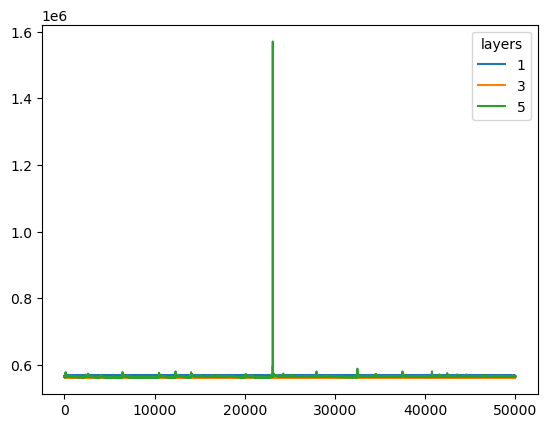

In [8]:
guide = guide_test
model = model_test

for nh in num_hn[-3:-2]:
        for depth in range(1, 6, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-3))
                svi = SVI(model, guide, optimizer, TraceMeanField_ELBO(num_particles=20))

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 100000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=512);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, model, results.params, dense_net, test_ds['image'], test_ds['label'], guide=guide, num_samples=10)

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

1 80


100%|██████████| 100000/100000 [07:05<00:00, 234.95it/s, init loss: 758195.7500, avg. loss [95001-100000]: 566521.1250]


0.76221 0.029164957
3 80


100%|██████████| 100000/100000 [10:16<00:00, 162.31it/s, init loss: 723088.8750, avg. loss [95001-100000]: 555165.5625]


0.86935997 0.00069598
5 80


100%|██████████| 100000/100000 [13:29<00:00, 123.54it/s, init loss: 747331.1875, avg. loss [95001-100000]: 553703.6250]


0.87552994 0.0004050887


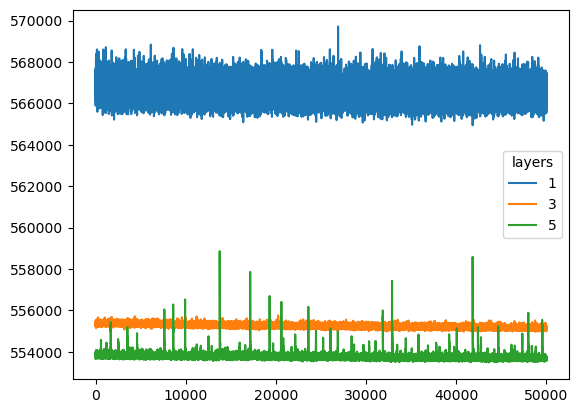

In [41]:
guide = partial(ktied_guide, 5)
model = model_test

for nh in num_hn[-3:-2]:
        for depth in range(1, 6, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-3))
                svi = SVI(model, guide, optimizer, TraceMeanField_ELBO(num_particles=10))

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 100000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=1024);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, model, results.params, dense_net, test_ds['image'], test_ds['label'], guide=guide, num_samples=10)

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

## Bayesian model reduction for deep learning

Let us start with the following full generative model with normal priors over network parameters

\begin{equation}
    \begin{split}
        b_{li} &\sim \mathcal{N}\left(0, 1 \right) \\
        \omega_{lij} &\sim \mathcal{N}\left(0, 1 \right) \\
        y_n &\sim p\left(y| \pmb{W}, \pmb{X}_n  \right)
    \end{split}
\end{equation}

We look for the posterior in the form 
\begin{equation}
    \begin{split}
        p\left( \pmb{b}, \pmb{W}|\pmb{\mathcal{D}}\right) & \approx \prod_l \prod_i q\left(\pmb{b}_{li} \right) \prod_j q\left( \omega_{lij} \right)  \\
        q\left(\pmb{b}_{li} \right) &= \mathcal{N}\left(\pmb{\mu}_{li}^b, [\sigma^b_{li}]^2 \right) \\
        q\left( \pmb{W}_{li} \right) &= \mathcal{N}_{kt} \left( \pmb{\mu}_{lij}^\omega, \pmb{\pi}^{-1}_{lij}  \right)
    \end{split}
\end{equation}
where $\pmb{\pi}^{-1}_{lij} = [\sum_k u_{lik} v_{lkj}]^2 $.

The reduced model introduces the following hierarchical prior over network weights

\begin{equation}
    \begin{split}
        c_l^2 &\sim \Gamma\left(2, 2 \right) \\
        \tau_{li} &\sim \mathcal{C}^{+}(0, 1) \\
        \lambda_{lij} &\sim \mathcal{C}^{+}(0, 1) \\
        \gamma^2_{lij} & = \frac{c_l^2 \tau^2_{li}\lambda^2_{lij}}{c_l^2 + \tau^2_{li}\lambda^2_{lij} } \\
        \omega_{lij} &\sim \mathcal{N}\left(0, \gamma^2_{lij} \right)
    \end{split}
\end{equation}

The change in the variational free energy is obtained as 

\begin{equation}
    \begin{split}
        \tilde{\pi}_{lij} &= \pi_{lij} + \gamma^{-2}_{lij} - \pi_0 \\
        \tilde{\mu}_{lij} &= \tilde{\pi}_{lij}^{-1} \pi_{lij} \mu_{lij} \\
        \Delta F\left( G \right) &= \ln E_{q(\pmb{W})}\left[ \frac{\tilde{p}(\pmb{W}| \pmb{G})}{p(\pmb{W})}\right] \\

        &= \frac{1}{2}\sum_{lij} \left[ \ln \left(\gamma^{-2}_{lij} \pi_{lij} \tilde{\pi}^{-1}_{lij}\right)  - \mu_{lij}^2 \pi_{lij} + \tilde{\mu}^2_{lij}\tilde{\pi}_{lij} \right]\\
        &= \frac{1}{2}\sum_{lij} \left[ - \ln\left( \gamma_{lij}^2 + \sigma^2_{lij} - \pi_0 \gamma_{lij}^2 \sigma^2_{lij}\right) - \mu_{lij}^2\pi_{lij}\left(1 - \tilde{\pi}_{lij}^{-1} \pi_{lij} \right) \right] \\
    \end{split}
\end{equation}


where $ \pmb{G}_{lij} = \pmb{\gamma}^2_{lij}$.

In [6]:
from models import BMRDNN

def test_model(rng_key, params, nnet, images, labels, num_samples=10, bmr=False):
    n, _ = images.shape
    rng_key, _rng_key = random.split(rng_key)
    bmrdn = BMRDNN(_rng_key, nnet, images, subsample_size=n)
    model = bmrdn.model
    if bmr:
        guide = bmrdn.aux_guide
    else:
        guide = bmrdn.guide
    
    pred = Predictive(model, guide=guide, params=params, num_samples=num_samples)

    rng_key, _rng_key = random.split(rng_key)
    sample = pred(_rng_key)

    if num_samples > 1:
        acc = jnp.mean(sample['obs'] == labels, -1)
        print(acc.mean(), acc.std())
    else:
        print( jnp.mean(sample['obs'] == labels) )

In [23]:
devs = devices('gpu')

for nh in num_hn[-3:-2]:
    for depth in range(1, 6, 2):
        print(depth, nh)
        rng_key, _rng_key = random.split(rng_key)
        dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

        rng_key, _rng_key = random.split(rng_key)
        bmr_dnn = BMRDNN(_rng_key, dense_net, train_ds['image'], subsample_size=1024, sigma_0=4.)

        params = bmr_dnn.fit(train_ds['label'], num_steps=50000, num_particles=20)
        
        rng_key, _rng_key = random.split(rng_key)
        test_model(rng_key, params, dense_net, test_ds['image'], test_ds['label'], num_samples=10)

        params = lax.stop_gradient(params)
        bmr_res, samples = bmr_dnn.bmr(params, devs[1], num_samples=1000, num_steps=1000, num_particles=20, opt_kwargs={'learning_rate': 1e-2})

        bmr_pars = params.copy()
        for key in samples.keys():
            bmr_pars[key] = lax.stop_gradient(samples[key].mean(0))

        rng_key, _rng_key = random.split(rng_key)
        test_model(rng_key, bmr_pars, dense_net, test_ds['image'], test_ds['label'], num_samples=10, bmr=True)

1 80


100%|██████████| 50000/50000 [06:06<00:00, 136.48it/s, init loss: 346258.4688, avg. loss [47501-50000]: 33706.1602]


0.75497997 0.011142517


100%|██████████| 1000/1000 [00:06<00:00, 151.92it/s, init loss: 409361.0938, avg. loss [951-1000]: 106868.5469]


0.75653 0.0035880401
3 80


100%|██████████| 50000/50000 [08:28<00:00, 98.32it/s, init loss: 382765.7812, avg. loss [47501-50000]: 36222.5703] 


0.78209 0.006907166


100%|██████████| 1000/1000 [00:10<00:00, 94.22it/s, init loss: 487195.3438, avg. loss [951-1000]: 126072.0391]


0.5891 0.014043062
5 80


100%|██████████| 50000/50000 [14:16<00:00, 58.36it/s, init loss: 424181.2188, avg. loss [47501-50000]: 51383.6602]


0.69111 0.0092570465


100%|██████████| 1000/1000 [00:15<00:00, 65.65it/s, init loss: 557805.5000, avg. loss [951-1000]: 143055.2344]


0.36846 0.04435937


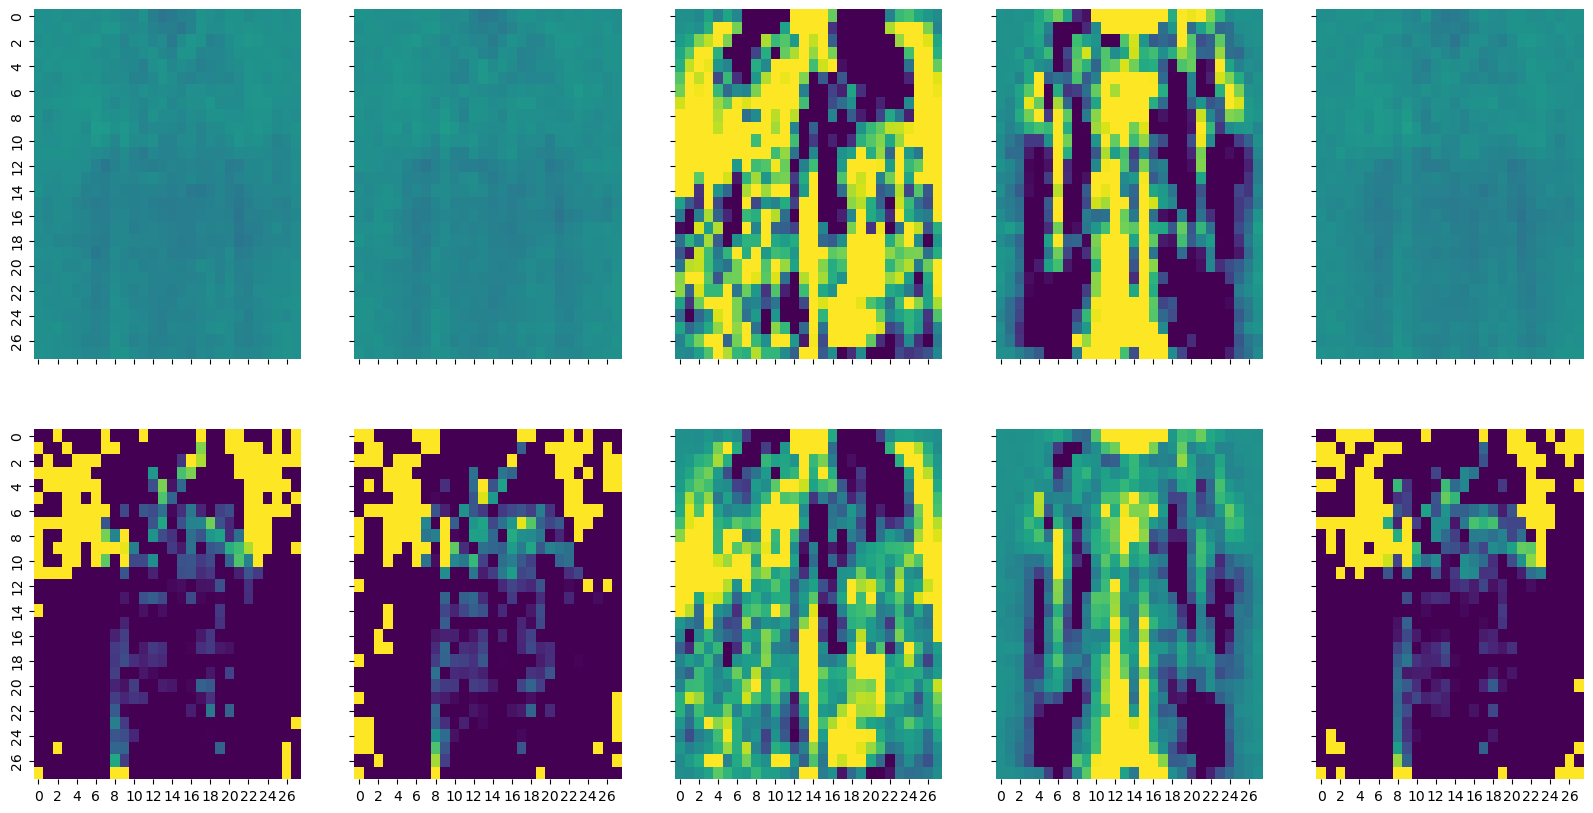

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True, sharex=True)

weight = params['loc.layer0.weight']
shrinked_weight = samples['loc.layer0.weight'].mean(0)

for i, ax in enumerate(axes[0]):
    sns.heatmap(weight[i].reshape(28, 28), ax=ax, cbar=False, cmap='viridis', vmin=-1, vmax=1)
    sns.heatmap(shrinked_weight[i].reshape(28, 28), ax=axes[1, i], cbar=False, cmap='viridis', vmin=-1, vmax=1)

In [21]:
scale = jnp.abs(params['scale_u.layer0.weight'] @ params['scale_v.layer0.weight'])
print(scale.min(), scale.max())

0.18005101 2.1119647


In [22]:
params['scale.layer0.bias']

DeviceArray([1.9609958 , 1.9582953 , 0.4050484 , 0.684495  , 1.9621029 ,
             1.9487286 , 0.4896011 , 1.971154  , 1.9890496 , 1.9820914 ,
             1.9538431 , 1.9797587 , 1.9710469 , 1.9772973 , 1.9788817 ,
             1.9755476 , 1.9920487 , 1.9987197 , 1.951998  , 1.9418701 ,
             1.960531  , 1.9773076 , 1.9783714 , 1.969383  , 1.994448  ,
             1.9826978 , 0.4446643 , 1.9769264 , 1.9876782 , 1.9693575 ,
             1.989938  , 1.9477102 , 1.9728463 , 0.31279427, 0.08024149,
             1.948231  , 1.9768026 , 1.9697183 , 1.9648806 , 1.979186  ,
             1.9872339 , 1.9502075 , 1.9329299 , 1.9524322 , 1.9681301 ,
             1.9818735 , 1.9786061 , 0.412484  , 1.9493124 , 1.9697192 ,
             2.0132935 , 1.9913064 , 1.9814883 , 1.9528589 , 1.9454027 ,
             1.9652563 , 1.9410745 , 1.9999352 , 1.9690785 , 1.9789089 ,
             1.9937489 , 0.19134939, 1.9451439 , 1.9571441 , 1.9409025 ,
             1.9713991 , 1.9863914 , 1.9852647 , 1.